# Semantic Segmentation (2D)


This exercise will demonstrate a very simple approach to perform *semantic segmentation* with convolutional neural networks. *Semantic segmentation* means, we aim to assign every pixel of the input image one of several different classes (background, cell interior, cell boundary) without distinguishing objects of the same class.

![](_images/task_semantic.png)

## Setup and imports

In [16]:
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from datetime import datetime
from tifffile import imread
from pathlib import Path
import skimage
from skimage.segmentation import find_boundaries
from augmend import Augmend, FlipRot90, Elastic, AdditiveNoise, IntensityScaleShift, Identity
import tensorflow as tf

from model import UNet, UNetConfig


/var/folders/g1/m77h0b_d0fs7ymvpdv3l6n4h0000gr/T/ipykernel_78239/2602698817.py:3: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  matplotlib.rcParams["image.interpolation"] = None


## Data


First we download some sample images and corresponding masks

In [2]:
from csbdeep.utils import download_and_extract_zip_file, normalize

download_and_extract_zip_file(
    url       = 'https://github.com/mpicbg-csbd/stardist/releases/download/0.1.0/dsb2018.zip',
    targetdir = 'data',
    verbose   = 1,
)

Files found, nothing to download.


Next we load the data, generate from the annotation masks background/foreground/cell border masks, and crop out a central patch (this is just for simplicity, as it makes our life a bit easier when all images have the same shape)

In [3]:

def crop(u,shape=(256,256)):
    """Crop central region of given shape"""
    return u[tuple(slice((s-m)//2,(s-m)//2+m) for s,m in zip(u.shape,shape))]

def to_3class_label(lbl, onehot=True):
    """Convert instance labeling to background/inner/outer mask"""
    b = find_boundaries(lbl,mode='outer')
    res = (lbl>0).astype(np.uint8)
    res[b] = 2
    if onehot:
        res = tf.keras.utils.to_categorical(res,num_classes=3).reshape(lbl.shape+(3,))
    return res

# load and crop out central patch (for simplicity)
X   = [normalize(crop(imread(x))) for x in sorted(glob('data/dsb2018/train/images/*.tif'))]
Y   = [to_3class_label(crop(imread(y))) for y in sorted(glob('data/dsb2018/train/masks/*.tif'))]

# convert to numpy arrays
X, Y = np.expand_dims(np.stack(X),-1), np.stack(Y)

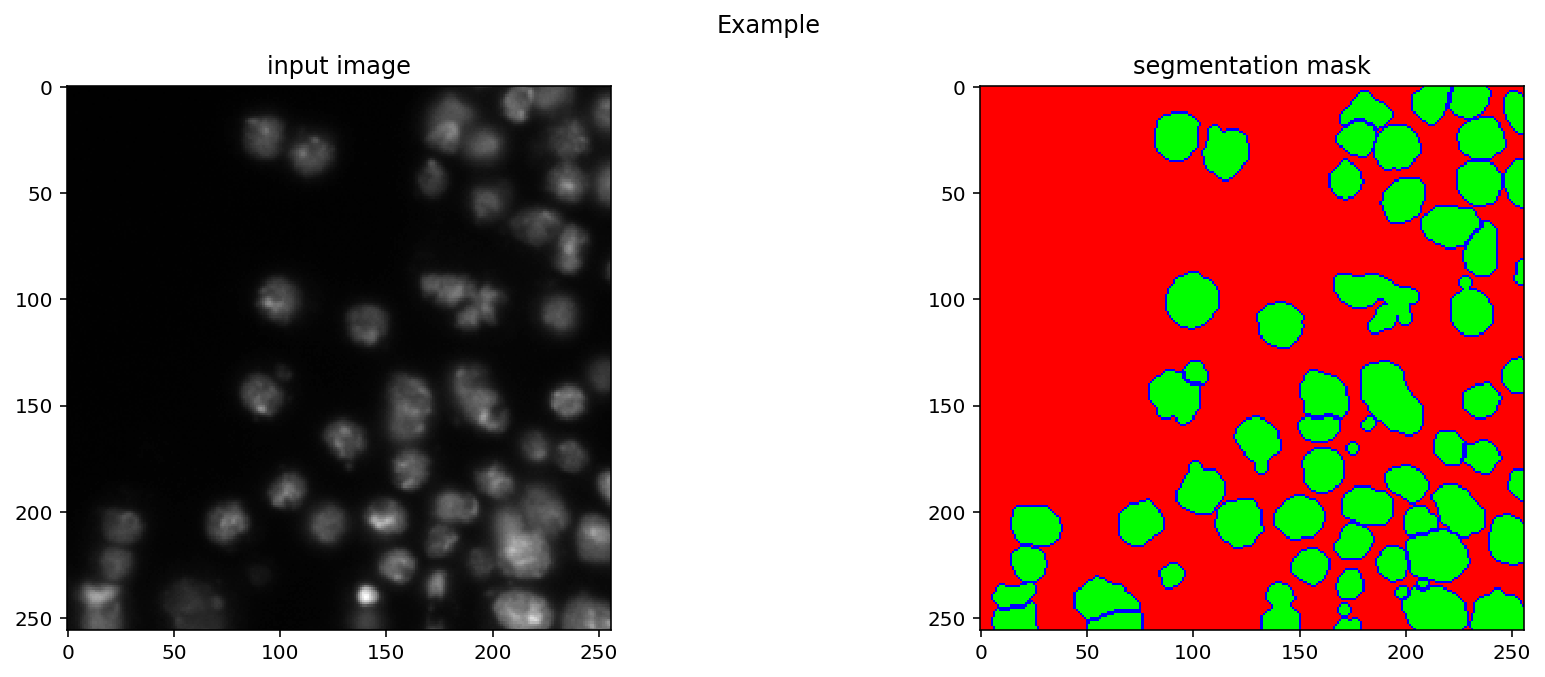

In [4]:
# plot an example image
i = 3
fig, (a0,a1) = plt.subplots(1,2,figsize=(15,5))
a0.imshow(X[i,...,0],cmap='gray');  
a0.set_title('input image')
a1.imshow(Y[i]);                    
a1.set_title('segmentation mask')
fig.suptitle("Example")
None;

<div class="alert alert-block alert-info"><h2>Exercise</h2> 
    

1)  Plot some more images. What kind of data is shown? How variable is it? Do the segmentation masks look reasonable? 
        
</div>


We now split the training data into ~ 80/20 training and validation data

In [5]:
from csbdeep.data import shuffle_inplace

# shuffle data
shuffle_inplace(X, Y, seed=0)

# split into 80% training and 20% validation images
n_val = len(X) // 5
def split_train_val(a):
    return a[:-n_val], a[-n_val:]
X_train,       X_val       = split_train_val(X)
Y_train,       Y_val       = split_train_val(Y)

print(f'training   data: {len(X_train)} images and {len(Y_train)} masks')
print(f'validation data: {len(X_val)} images and {len(Y_val)} masks')

training   data: 358 images and 358 masks
validation data: 89 images and 89 masks


## Building a UNet 

We now will construct a very simple 3-class segmentation model, for which we will use a UNet 

<img width=400 src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png"></img>

For the actual implementation, we will make use of the function `custom_unet` from `csbdeep.internals.nets`

In [17]:
config = UNetConfig(n_dim=2, n_channel_in=1, n_channel_out=3,train_loss='dice_cce')
config

UNetConfig(n_dim=2, axes='XYC', n_channel_in=1, n_channel_out=3, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', probabilistic=False, unet_residual=False, unet_n_depth=4, unet_kern_size=3, unet_n_first=32, unet_last_activation='softmax', unet_input_shape=(None, None, 1), train_loss='dice_cce', train_epochs=100, train_steps_per_epoch=400, train_learning_rate=0.0004, train_batch_size=16, train_tensorboard=True, train_reduce_lr={'factor': 0.5, 'patience': 10, 'min_delta': 0}, train_class_weight=(1, 1, 1), unet_batch_norm=False, unet_dropout=0.0, patch_size=(128, 128))

In [18]:
model = UNet(config, 'models/unet')

model.keras_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 down_level_0_no_0 (Conv2D)     (None, None, None,   320         ['input[0][0]']                  
                                32)                                                               
                                                                                                  
 down_level_0_no_1 (Conv2D)     (None, None, None,   9248        ['down_level_0_no_0[0][0]']      
                                32)                                                         

<div class="alert alert-block alert-info"><h2>Exercise</h2> 
    

1) What is the intuition about the gray "skip connections"? 
    
2) Apply the (untrained) model on a example image (with `model.predict`). What is the output? How is it normalized?


</div>

### Augmentations



In [19]:
aug = Augmend()
aug.add([FlipRot90(axis=(0, 1)), FlipRot90(axis=(0, 1))])
aug.add([AdditiveNoise(sigma=(0, 0.05)), Identity()], probability=.5)
aug.add([IntensityScaleShift(scale=(.7, 1.2), shift=(-0.1, 0.1), axis=(0, 1, 2)), Identity()])


In [20]:
model.train(X_train, Y_train, X_val,Y_val, augmenter=aug, epochs=100,steps_per_epoch=100)

Epoch 1/100
100/100 [==============================] - 14s 124ms/step - loss: 0.6743 - metric_precision: 0.8563 - metric_recall: 0.7872 - metric_f1: 0.8045 - val_loss: 0.2981 - val_metric_precision: 0.9724 - val_metric_recall: 0.9591 - val_metric_f1: 0.9657 - lr: 4.0000e-04
Epoch 2/100
100/100 [==============================] - 12s 119ms/step - loss: 0.3169 - metric_precision: 0.9678 - metric_recall: 0.9459 - metric_f1: 0.9567 - val_loss: 0.2574 - val_metric_precision: 0.9776 - val_metric_recall: 0.9616 - val_metric_f1: 0.9695 - lr: 4.0000e-04
Epoch 3/100
100/100 [==============================] - 12s 121ms/step - loss: 0.2816 - metric_precision: 0.9689 - metric_recall: 0.9508 - metric_f1: 0.9597 - val_loss: 0.2418 - val_metric_precision: 0.9767 - val_metric_recall: 0.9631 - val_metric_f1: 0.9699 - lr: 4.0000e-04
Epoch 4/100
100/100 [==============================] - 12s 117ms/step - loss: 0.2586 - metric_precision: 0.9696 - metric_recall: 0.9558 - metric_f1: 0.9626 - val_loss: 0.2357 

KeyboardInterrupt: 

### Predict

In [ ]:
i=1

img  = X_val[i,..., 0]
mask = Y_val[i]
plt.imshow(img)


In [ ]:
mask_pred = model.predict(img[np.newaxis,...,np.newaxis])[0]
mask_pred.shape

In [ ]:
from skimage.measure import label

# threshold inner (green) and find connected components
lbl_pred = label(mask_pred[...,1] > 0.7)

fig, ((a0,a1),(b0,b1)) = plt.subplots(2,2,figsize=(15,10))
a0.imshow(img,cmap='gray');       
a0.set_title('input image')
a1.imshow(mask);                  
a1.set_title('GT segmentation mask')
b0.axis('off')
b0.imshow(lbl_pred,cmap='tab20'); 
b0.set_title('label image (prediction)')
b1.imshow(mask_pred);             
b1.set_title('segmentation mask (prediction)')
fig.suptitle("Example")
None;

<div class="alert alert-block alert-info"><h2>Exercise</h2> 
    

Can you spot the label image mistakes? What could be the reason?
    
 

</div>